# Essentiality vs. GWAS Comparison

In [ ]:
import logging
import os
import re
import textwrap

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
from tqdm import tqdm
from scipy import stats
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests

from src.config import conf
from src.constants import TORCH_DEVICE
from src.dataloaders import load_graph
from src.models import HGT

if any("Arial" in f.name for f in fm.fontManager.ttflist):
    plt.rcParams["font.family"] = "Arial"

_logger = logging.getLogger(__name__)

## Load KG and Model

Load knowledge graph and embeddings.

In [2]:
nodes = pd.read_csv(conf.paths.kg.nodes_path, dtype={"node_index": int}, low_memory=False)
edges = pd.read_csv(
    conf.paths.kg.edges_path, dtype={"edge_index": int, "x_index": int, "y_index": int}, low_memory=False
)
embeddings = torch.load(conf.paths.checkpoint.embeddings_path)
_logger.info(f"Number of nodes: {len(nodes)}")
_logger.info(f"Number of edges: {len(edges) / 2:.0f}")

[12/10/25 13:35:03] INFO     Number of nodes: 147020                                                ]8;id=876062;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3830599195.py\3830599195.py]8;;\:]8;id=910818;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3830599195.py#6\6]8;;\

                    INFO     Number of edges: 7366745                                               ]8;id=177187;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3830599195.py\3830599195.py]8;;\:]8;id=701986;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3830599195.py#7\7]8;;\

Load pre-trained model.

In [3]:
pl.seed_everything(conf.seed, workers=True)
kg = load_graph(nodes, edges)
pretrain_model = HGT.load_from_checkpoint(
    checkpoint_path=str(conf.paths.checkpoint.checkpoint_path),
    kg=kg,
    strict=False,
)
pretrain_model.eval()
pretrain_model = pretrain_model.to(TORCH_DEVICE)

# Make output directory
os.makedirs(conf.paths.notebooks.essentiality_gwas_dir, exist_ok=True)

Seed set to 42


## Read GWAS Hits

In [4]:
def read_gene_list(sheet_name: str):
    gene_colnames = ["genes", "source"] if sheet_name == "PD_genes_GWAS_RVAS" else ["genes"]
    gene_list = pd.read_excel(
        conf.paths.notebooks.pd_related_genes,
        sheet_name=sheet_name,
        header=None,
        names=gene_colnames,
    )
    original_gene_count = gene_list.shape[0]
    gene_list = pd.merge(nodes, gene_list, left_on="node_name", right_on="genes", how="inner")
    _logger.info(f"Genes in {sheet_name}: {original_gene_count}, {gene_list.shape[0]} in KG")
    return gene_list


essentiality_genes = read_gene_list("DA_essentiality_full")

# Read PD genes
pd_genes = read_gene_list("PD_genes_GWAS_RVAS")
pd_eqtl_genes = read_gene_list("PD_eQTL_SMR_MR_hits")
pd_genes = pd.concat([pd_genes, pd_eqtl_genes])
pd_genes = pd_genes.drop_duplicates(subset="node_index").reset_index(drop=True)
_logger.info(f"Total unique PD genes: {pd_genes.shape[0]}")

[12/10/25 13:35:19] INFO     Genes in DA_essentiality_full: 693, 681 in KG                          ]8;id=234053;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/592439051.py\592439051.py]8;;\:]8;id=146316;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/592439051.py#11\11]8;;\

                    INFO     Genes in PD_genes_GWAS_RVAS: 249, 242 in KG                            ]8;id=935518;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/592439051.py\592439051.py]8;;\:]8;id=571858;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/592439051.py#11\11]8;;\

                    INFO     Genes in PD_eQTL_SMR_MR_hits: 54, 52 in KG                             ]8;id=31244;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/592439051.py\592439051.py]8;;\:]8;id=98246;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/592439051.py#11\11]8;;\

                    INFO     Total unique PD genes: 288                                             ]8;id=588508;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/592439051.py\592439051.py]8;;\:]8;id=208496;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/592439051.py#22\22]8;;\

Read GWAS lists from GWAS catalog.

In [5]:
disease_map = {
    "EFO_0000537": "hypertension",
    "EFO_0001645": "coronary artery disease",
    "EFO_0003767": "inflammatory bowel disease",
    "EFO_0003884": "chronic kidney disease",
    "MONDO_0002009": "major depressive disorder",
    "MONDO_0004975": "Alzheimer disease",
    "MONDO_0004979": "asthma",
    "MONDO_0005148": "type 2 diabetes mellitus",
    "MONDO_0007254": "breast cancer",
    "MONDO_0004976": "amyotrophic lateral sclerosis",
}


GWAS_files = list(conf.paths.notebooks.gwas_catalog.glob("*.tsv"))

# Read each file into a dictionary
GWAS_dict = {}
for file in GWAS_files:
    
    # Name of the disease, remove _associations_export.tsv
    disease_id = file.stem.replace("_associations_export", "")
    GWAS_dict[disease_id] = pd.read_csv(file, sep="\t", low_memory=False)

# Convert to GWAS genes
GWAS_genes = {}
unique_genes = set()
for disease_id, df in GWAS_dict.items():

    gene_list = df["mappedGenes"].str.split(",").explode().unique()
    original_count = len(gene_list)

    # Subset to genes in KG
    gene_list = pd.merge(nodes, pd.DataFrame({"genes": gene_list}), left_on="node_name", right_on="genes", how="inner")
    disease_name = disease_map[disease_id]
    _logger.info(f"Genes in {disease_name}: {original_count}, {gene_list.shape[0]} in KG")

    GWAS_genes[disease_name] = gene_list
    unique_genes.update(gene_list["node_name"])

gene_lists = GWAS_genes
gene_lists["Parkinson disease"] = pd_genes
_logger.info(f"Genes in Parkinson disease: {len(gene_lists['Parkinson disease'])}")
_logger.info(f"Unique genes: {len(unique_genes)}")

                    INFO     Genes in inflammatory bowel disease: 1273, 1137 in KG                  ]8;id=471029;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py\430368491.py]8;;\:]8;id=617889;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py#36\36]8;;\

                    INFO     Genes in coronary artery disease: 1525, 1370 in KG                     ]8;id=795667;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py\430368491.py]8;;\:]8;id=844962;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py#36\36]8;;\

                    INFO     Genes in Alzheimer disease: 3073, 2686 in KG                           ]8;id=291369;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py\430368491.py]8;;\:]8;id=163032;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py#36\36]8;;\

                    INFO     Genes in type 2 diabetes mellitus: 2886, 2572 in KG                    ]8;id=97251;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py\430368491.py]8;;\:]8;id=398382;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py#36\36]8;;\

                    INFO     Genes in major depressive disorder: 2288, 1978 in KG                   ]8;id=633052;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py\430368491.py]8;;\:]8;id=277370;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py#36\36]8;;\

                    INFO     Genes in hypertension: 1215, 1086 in KG                                ]8;id=562275;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py\430368491.py]8;;\:]8;id=130889;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py#36\36]8;;\

                    INFO     Genes in amyotrophic lateral sclerosis: 299, 268 in KG                 ]8;id=307419;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py\430368491.py]8;;\:]8;id=869693;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py#36\36]8;;\

                    INFO     Genes in chronic kidney disease: 490, 434 in KG                        ]8;id=379201;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py\430368491.py]8;;\:]8;id=605397;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py#36\36]8;;\

                    INFO     Genes in breast cancer: 1384, 1220 in KG                               ]8;id=693384;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py\430368491.py]8;;\:]8;id=238968;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py#36\36]8;;\

                    INFO     Genes in asthma: 1332, 1185 in KG                                      ]8;id=244098;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py\430368491.py]8;;\:]8;id=908573;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py#36\36]8;;\

                    INFO     Genes in Parkinson disease: 288                                        ]8;id=874628;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py\430368491.py]8;;\:]8;id=382554;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py#43\43]8;;\

                    INFO     Unique genes: 8976                                                     ]8;id=279946;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py\430368491.py]8;;\:]8;id=735911;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/430368491.py#44\44]8;;\

In [6]:
GWAS_studies_path = conf.paths.notebooks.gwas_catalog / "studies"
GWAS_studies_files = list(GWAS_studies_path.glob("*.tsv"))

# Read each file into a dictionary
GWAS_studies_dict = {}
for file in GWAS_studies_files:
    disease_id = file.stem.replace("_studies_export", "")
    disease_name = disease_map[disease_id]
    GWAS_studies_dict[disease_name] = pd.read_csv(file, sep="\t", low_memory=False)


def safe_split(text):
    # Insert space after comma if followed directly by a digit
    return re.sub(r",(?=\d)", ", ", text)


all_pubmed_ids = set()
disease_pubmed_ids = {}
for disease_name, df in GWAS_studies_dict.items():
    _logger.info(f"\nDisease: {disease_name}")
    # Get unique pubmedIds
    unique_pubmed_ids = df["pubmedId"].unique()
    _logger.info(f"Unique PubMed IDs: {len(unique_pubmed_ids)}")
    all_pubmed_ids.update(unique_pubmed_ids)
    disease_pubmed_ids[disease_name] = unique_pubmed_ids

_logger.info(f"\nTotal unique PubMed IDs: {len(all_pubmed_ids)}")

                    INFO                                                                            ]8;id=179451;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=560086;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#20\20]8;;\
                             Disease: chronic kidney disease                                                       

                    INFO     Unique PubMed IDs: 57                                                  ]8;id=283060;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=970342;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#23\23]8;;\

                    INFO                                                                            ]8;id=717870;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=340035;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#20\20]8;;\
                             Disease: inflammatory bowel disease                                                   

                    INFO     Unique PubMed IDs: 103                                                 ]8;id=240174;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=861722;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#23\23]8;;\

                    INFO                                                                            ]8;id=280746;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=69403;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#20\20]8;;\
                             Disease: hypertension                                                                 

                    INFO     Unique PubMed IDs: 92                                                  ]8;id=918938;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=752787;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#23\23]8;;\

                    INFO                                                                            ]8;id=414850;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=927657;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#20\20]8;;\
                             Disease: asthma                                                                       

                    INFO     Unique PubMed IDs: 103                                                 ]8;id=277746;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=146413;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#23\23]8;;\

                    INFO                                                                            ]8;id=275504;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=783300;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#20\20]8;;\
                             Disease: Alzheimer disease                                                            

                    INFO     Unique PubMed IDs: 120                                                 ]8;id=418801;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=379580;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#23\23]8;;\

                    INFO                                                                            ]8;id=95325;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=792495;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#20\20]8;;\
                             Disease: breast cancer                                                                

                    INFO     Unique PubMed IDs: 113                                                 ]8;id=657924;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=167753;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#23\23]8;;\

                    INFO                                                                            ]8;id=66613;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=403457;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#20\20]8;;\
                             Disease: type 2 diabetes mellitus                                                     

                    INFO     Unique PubMed IDs: 153                                                 ]8;id=263626;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=580099;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#23\23]8;;\

                    INFO                                                                            ]8;id=755731;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=120116;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#20\20]8;;\
                             Disease: amyotrophic lateral sclerosis                                                

                    INFO     Unique PubMed IDs: 33                                                  ]8;id=279786;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=805934;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#23\23]8;;\

                    INFO                                                                            ]8;id=455884;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=165840;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#20\20]8;;\
                             Disease: major depressive disorder                                                    

                    INFO     Unique PubMed IDs: 119                                                 ]8;id=754639;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=276183;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#23\23]8;;\

                    INFO                                                                            ]8;id=956959;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=111579;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#20\20]8;;\
                             Disease: coronary artery disease                                                      

                    INFO     Unique PubMed IDs: 110                                                 ]8;id=669987;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=532323;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#23\23]8;;\

                    INFO                                                                            ]8;id=169396;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py\174072183.py]8;;\:]8;id=565579;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/174072183.py#27\27]8;;\
                             Total unique PubMed IDs: 863                                                          

In [7]:
hgnc = pd.read_csv(conf.paths.mappings.hgnc_path, sep="\t", low_memory=False)
protein_coding_genes = hgnc[hgnc["Locus group"] == "protein-coding gene"]

# Subset to protein coding genes
gene_nodes = nodes[nodes["node_type"] == "gene/protein"]
_logger.info(f"All genes: {len(gene_nodes)}")
gene_nodes = gene_nodes[gene_nodes["node_name"].isin(protein_coding_genes["Approved symbol"])]
_logger.info(f"Protein coding genes: {len(gene_nodes)}")

# Subset essentiality genes to protein coding genes
_logger.info("\nSubsetting essentiality genes to protein coding genes")
_logger.info(f"Original: {len(essentiality_genes)}")
essentiality_genes = essentiality_genes[essentiality_genes["node_name"].isin(protein_coding_genes["Approved symbol"])]
_logger.info(f"Protein coding genes: {len(essentiality_genes)}")

# Subset to protein-coding genes
pc_gene_lists = {}
_logger.info("\nSubsetting to protein-coding genes")
for list_name in gene_lists:
    pc_gene_lists[list_name] = gene_lists[list_name][
        gene_lists[list_name]["node_name"].isin(protein_coding_genes["Approved symbol"])
    ]
    _logger.info(
        f"Disease: {list_name} \t Original: {len(gene_lists[list_name])} \t Protein-Coding: {len(pc_gene_lists[list_name])}"
    )

# Drop essentiality genes from 
_logger.info("\nDropping essentiality genes")
for list_name in pc_gene_lists:
    original_count = len(pc_gene_lists[list_name])
    pc_gene_lists[list_name] = pc_gene_lists[list_name][
        ~pc_gene_lists[list_name]["node_name"].isin(essentiality_genes["node_name"])
    ]
    _logger.info(
        f"Disease: {list_name} \t Original: {original_count} \t Without Essentiality: {len(pc_gene_lists[list_name])}"
    )

                    INFO     All genes: 35198                                                       ]8;id=628038;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=339902;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#6\6]8;;\

                    INFO     Protein coding genes: 19179                                            ]8;id=921406;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=872064;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#8\8]8;;\

                    INFO                                                                           ]8;id=920659;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=594916;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#11\11]8;;\
                             Subsetting essentiality genes to protein coding genes                                 

                    INFO     Original: 681                                                         ]8;id=855662;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=72574;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#12\12]8;;\

                    INFO     Protein coding genes: 679                                             ]8;id=691798;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=498369;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#14\14]8;;\

                    INFO                                                                           ]8;id=914812;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=636059;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#18\18]8;;\
                             Subsetting to protein-coding genes                                                    

                    INFO     Disease: inflammatory bowel disease      Original: 1137               ]8;id=765388;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=723378;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#23\23]8;;\
                             Protein-Coding: 855                                                                   

                    INFO     Disease: coronary artery disease         Original: 1370               ]8;id=704314;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=681446;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#23\23]8;;\
                             Protein-Coding: 1049                                                                  

                    INFO     Disease: Alzheimer disease       Original: 2686                       ]8;id=473417;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=126882;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#23\23]8;;\
                             Protein-Coding: 1891                                                                  

                    INFO     Disease: type 2 diabetes mellitus        Original: 2572               ]8;id=22056;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=616886;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#23\23]8;;\
                             Protein-Coding: 1878                                                                  

                    INFO     Disease: major depressive disorder       Original: 1978               ]8;id=7540;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=74441;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#23\23]8;;\
                             Protein-Coding: 1332                                                                  

                    INFO     Disease: hypertension    Original: 1086          Protein-Coding: 808  ]8;id=70674;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=949401;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#23\23]8;;\

                    INFO     Disease: amyotrophic lateral sclerosis   Original: 268                ]8;id=539131;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=249565;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#23\23]8;;\
                             Protein-Coding: 175                                                                   

                    INFO     Disease: chronic kidney disease          Original: 434                ]8;id=565427;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=138739;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#23\23]8;;\
                             Protein-Coding: 305                                                                   

                    INFO     Disease: breast cancer   Original: 1220          Protein-Coding: 837  ]8;id=604201;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=495631;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#23\23]8;;\

                    INFO     Disease: asthma          Original: 1185          Protein-Coding: 857  ]8;id=426833;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=199659;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#23\23]8;;\

                    INFO     Disease: Parkinson disease       Original: 288   Protein-Coding: 279  ]8;id=371507;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=444154;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#23\23]8;;\

                    INFO                                                                           ]8;id=706073;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=685197;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#28\28]8;;\
                             Dropping essentiality genes                                                           

                    INFO     Disease: inflammatory bowel disease      Original: 855   Without      ]8;id=355784;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=839482;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#34\34]8;;\
                             Essentiality: 819                                                                     

                    INFO     Disease: coronary artery disease         Original: 1049               ]8;id=199448;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=562336;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#34\34]8;;\
                             Without Essentiality: 1003                                                            

                    INFO     Disease: Alzheimer disease       Original: 1891          Without      ]8;id=292075;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=485100;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#34\34]8;;\
                             Essentiality: 1816                                                                    

                    INFO     Disease: type 2 diabetes mellitus        Original: 1878               ]8;id=464656;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=847272;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#34\34]8;;\
                             Without Essentiality: 1810                                                            

                    INFO     Disease: major depressive disorder       Original: 1332               ]8;id=53045;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=683823;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#34\34]8;;\
                             Without Essentiality: 1275                                                            

                    INFO     Disease: hypertension    Original: 808   Without Essentiality: 772    ]8;id=971366;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=790170;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#34\34]8;;\

                    INFO     Disease: amyotrophic lateral sclerosis   Original: 175   Without      ]8;id=509231;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=504740;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#34\34]8;;\
                             Essentiality: 166                                                                     

                    INFO     Disease: chronic kidney disease          Original: 305   Without      ]8;id=61483;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=172634;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#34\34]8;;\
                             Essentiality: 299                                                                     

                    INFO     Disease: breast cancer   Original: 837   Without Essentiality: 809    ]8;id=971524;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=822157;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#34\34]8;;\

                    INFO     Disease: asthma          Original: 857   Without Essentiality: 826    ]8;id=730429;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=765990;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#34\34]8;;\

                    INFO     Disease: Parkinson disease       Original: 279   Without              ]8;id=510311;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py\1773170980.py]8;;\:]8;id=162316;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1773170980.py#34\34]8;;\
                             Essentiality: 251                                                                     

## Predict Interaction Scores

In [8]:
essentiality_df = gene_nodes.copy()
results_dict = {}

for i, row in tqdm(essentiality_genes.iterrows(), total=len(essentiality_genes)):
    essentiality_gene_name = row["node_name"]
    essentiality_gene_idx = row["node_index"]

    essentiality_gene_sim = pretrain_model.get_scores_from_embeddings(
        [essentiality_gene_idx],
        list(gene_nodes["node_index"].values),
        ("gene/protein", "protein_protein", "gene/protein"),
        embeddings=embeddings, query_kg=kg, use_cache=False
    )

    results_dict[essentiality_gene_name] = essentiality_gene_sim.cpu().numpy()

results_df = pd.DataFrame(results_dict, index=essentiality_df.index)
essentiality_df = pd.concat([essentiality_df, results_df], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 679/679 [00:09<00:00, 72.50it/s]


Remove known interactors.

In [9]:
ppi_edges = edges[(edges["relation"] == "protein_protein") | (edges["relation"] == "rev_protein_protein")].reset_index(
    drop=True
)
total_num_known_interactors = {}
essentiality_df_known = essentiality_df.copy()

# For each essentiality gene, replace known PPI predictions in essentiality_df with None
for i, row in tqdm(essentiality_genes.iterrows(), total=len(essentiality_genes)):
    essentiality_gene_name = row["node_name"]
    essentiality_gene_idx = row["node_index"]

    # Get all PPI edges for the essentiality gene
    ppi_edges_for_gene = ppi_edges[ppi_edges["x_index"] == essentiality_gene_idx]
    known_interactors = ppi_edges_for_gene["y_index"].values

    # Count number of known interactors in essentiality_df
    num_known_interactors = essentiality_df[essentiality_df["node_index"].isin(known_interactors)].shape[0]
    total_num_known_interactors[essentiality_gene_name] = num_known_interactors

    # Replace known interactors with None
    essentiality_df.loc[essentiality_df["node_index"].isin(known_interactors), essentiality_gene_name] = None

    # Replace all BUT known interactors with None
    essentiality_df_known.loc[~essentiality_df_known["node_index"].isin(known_interactors), essentiality_gene_name] = (
        None
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 679/679 [00:01<00:00, 570.85it/s]


In [10]:
meta_cols = ["node_index", "node_id", "node_type", "node_name", "node_source"]
ess_cols = [c for c in essentiality_df.columns if c not in meta_cols]

meta_lookup = (
    essentiality_df.loc[essentiality_df["node_name"].isin(ess_cols), meta_cols]  # <- unique rows
    .drop_duplicates("node_name")
    .set_index("node_name")
)

In [11]:
rank_mat = (
    essentiality_df[ess_cols]
    .rank(ascending=False, method="min")  # 1 = strongest score
    .assign(node_index=essentiality_df["node_index"])
    .set_index("node_index")
)

disease_sets = {
    d: set(df["node_index"].unique())
    for d, df in pc_gene_lists.items()
}

In [12]:
agg_rank_by_dis = {}
for d, idx_set in disease_sets.items():
    
    # Keep only indices that actually exist in rank_mat
    idx = list(idx_set & set(rank_mat.index))

    # If the gene list is empty, skip or fill with NaNs
    if not idx:
        agg_rank_by_dis[d] = pd.Series(np.nan, index=ess_cols)
        continue

    # Compute median rank
    agg_rank_by_dis[d] = rank_mat.loc[idx].median()

In [13]:
agg_rank_df = pd.DataFrame(agg_rank_by_dis)

# Compile final data frame
out_df = (
    meta_lookup.join(agg_rank_df)
    .reset_index()
    .rename(columns={"index": "node_name"})
    .sort_values("node_name")
)

# Save to CSV
out_df.to_csv(conf.paths.notebooks.essentiality_gwas_dir / "essentiality_rank_by_disease.csv", index=False)

## Plot Median Ranks

In [14]:
rank_cols = [c for c in out_df.columns if pc_gene_lists.keys().__contains__(c)]
plot_df = out_df.melt(id_vars=["node_name"], value_vars=rank_cols, var_name="Gene group", value_name="Aggregated rank")
plot_df["Gene group"] = plot_df["Gene group"].apply(lambda x: f"{x} ({len(pc_gene_lists[x]):,})")

# Order by median rank
order = (
    plot_df.groupby("Gene group")["Aggregated rank"]
    .median()
    .sort_values(ascending=True)
    .index
)

plot_df["Gene group"] = pd.Categorical(plot_df["Gene group"], categories=order, ordered=True)

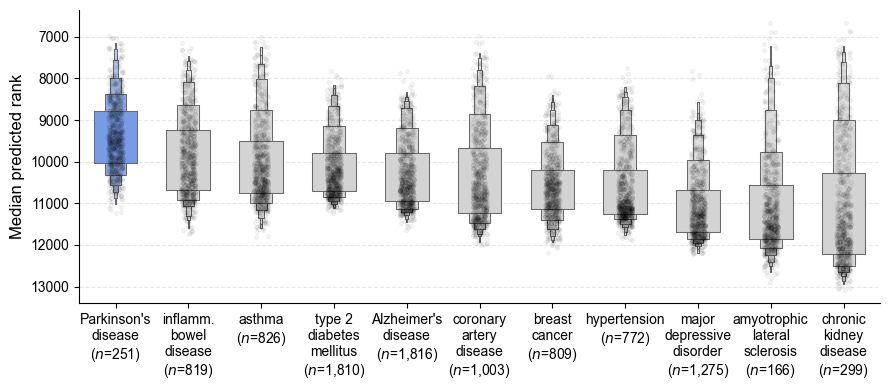

In [15]:
plt.figure(figsize=(9, 4))

# Make PD color more distinct
palette = {
    f"Parkinson disease ({len(pc_gene_lists['Parkinson disease'])})": "#6695F8",
}
missing_colors = set(plot_df["Gene group"]) - set(palette)
for color in missing_colors:
    palette[color] = "#D3D3D3"

sns.boxenplot(
    x="Gene group",
    y="Aggregated rank",
    data=plot_df,
    order=order,
    palette=palette,
    hue="Gene group",
    width=0.6,
    showfliers=False,
    zorder=3,
)

sns.stripplot(
    x="Gene group",
    y="Aggregated rank",
    data=plot_df,
    jitter=True,
    dodge=True,
    order=order,
    alpha=0.05,
    color="black",
    linewidth=0.5,
    s=3,
    zorder=5,
)

# Wrap x‑axis labels with textwrap
ax = plt.gca()
max_width = 12
wrapped_labels = []

for tick in ax.get_xticklabels():
    original = tick.get_text()
    wrapped = "\n".join(textwrap.wrap(original, width=max_width, break_long_words=True, break_on_hyphens=True))

    if "Parkinson" in original:
        wrapped = wrapped.replace("Parkinson\ndisease", "Parkinson's\ndisease")
    if "Alzheimer" in original:
        wrapped = wrapped.replace("Alzheimer\ndisease", "Alzheimer's\ndisease")
    if "inflammatory" in original:
        wrapped = wrapped.replace("inflammatory", "inflamm.")
    
    wrapped = wrapped.replace(" (", "\n(")
    wrapped = wrapped.replace("(", "($n$=")
    wrapped_labels.append(wrapped)

# Must redraw the labels after changing text
ticks = ax.get_xticks()
ax.set_xticks(ticks, labels=wrapped_labels, rotation=0)
plt.gca().invert_yaxis()

plt.xlabel("")
plt.ylabel("Median predicted rank", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.3, zorder=0)
sns.despine(top=True, right=True)
plt.tight_layout()

# Save figure
plt.savefig(conf.paths.notebooks.essentiality_gwas_dir / "essentiality_rank_boxplot.pdf", bbox_inches="tight")
plt.savefig(
    conf.paths.notebooks.essentiality_gwas_dir / "essentiality_rank_boxplot.png", dpi=600, bbox_inches="tight"
)
plt.savefig(conf.paths.notebooks.essentiality_gwas_dir / "essentiality_rank_boxplot.svg", bbox_inches="tight")
plt.show()

## Compute Statistics

First, compute the median and IQR of aggregated ranks for each disease.

In [16]:
def summarize_aggregated_ranks(df, disease_cols, label):
    rows = []
    for d in disease_cols:
        x = pd.to_numeric(df[d], errors='coerce').to_numpy()
        x = x[np.isfinite(x)]
        if x.size == 0:
            rows.append([d, np.nan, np.nan, np.nan, np.nan, 0])
            continue
        med = np.median(x)
        q1  = np.percentile(x, 25)
        q3  = np.percentile(x, 75)
        iqr = q3 - q1
        rows.append([d, med, q1, q3, iqr, x.size])

    out = pd.DataFrame(rows, columns=["disease", "median", "q1", "q3", "iqr", "n"])
    out = out.sort_values("median", ascending=True).reset_index(drop=True)

    # Lower median means stronger PROTON similarity
    _logger.info(f"\n=== Aggregated ranks summary: {label} ===")
    _logger.info(out.to_string(index=False, float_format=lambda v: f"{v:,.2f}"))
    return out

# Original lists
disease_cols = [c for c in out_df.columns if c in pc_gene_lists.keys()]
summary_full = summarize_aggregated_ranks(out_df, disease_cols, "Full disease gene sets")

[12/10/25 13:35:34] INFO                                                                             ]8;id=568532;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/66325527.py\66325527.py]8;;\:]8;id=63918;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/66325527.py#19\19]8;;\
                             === Aggregated ranks summary: Full disease gene sets ===                              

                    INFO                           disease    median        q1        q3      iqr    ]8;id=499948;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/66325527.py\66325527.py]8;;\:]8;id=527276;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/66325527.py#20\20]8;;\
                             n                                                                                     
                                         Parkinson disease  9,487.50  8,791.75 10,029.00 1,237.25                  
                             679                                                                                   
                                inflammatory bowel disease 10,020.00  9,230.00 10,670.25 1,440.25                  
                             679                                                                                   
                                                    asthma 10,276.50  9,507.75 10,756.50 1,248.75                  
                             679                                                                                   
                                  type 2 diabetes mellitus 10,321.50  9,791.50 10,701.00   909.50                  
                             679                                                                                   
                                         Alzheimer disease 10,523.50  9,795.00 10,948.00 1,153.00                  
                             679                                                                                   
                                   coronary artery disease 10,686.50  9,660.50 11,233.50 1,573.00                  
                             679                                                                                   
                                             breast cancer 10,698.50 10,205.25 11,142.25   937.00                  
                             679                                                                                   
                                              hypertension 10,985.00 10,201.00 11,247.75 1,046.75                  
                             679                                                                                   
                                 major depressive disorder 11,281.00 10,671.00 11,694.50 1,023.50                  
                             679                                                                                   
                             amyotrophic lateral sclerosis 11,441.50 10,551.75 11,857.50 1,305.75                  
                             679                                                                                   
                                    chronic kidney disease 11,601.00 10,267.50 12,225.00 1,957.50                  
                             679                                                                                   

Format it in one line for the manuscript.

In [17]:
df = summary_full

def format_median_q1q3_line(df, disease_col='disease', median_col='median', q1_col='q1', q3_col='q3',
                            include_n=False, style="colon"):
    items = []
    for _, r in df.iterrows():
        name = str(r[disease_col])
        med  = float(r[median_col])
        q1   = float(r[q1_col])
        q3   = float(r[q3_col])

        # Choose label style: "colon" -> "Disease: 9,487.50 [8,791.75–10,029.00]"
        # or "parens" -> "Disease (9,487.50 [8,791.75–10,029.00])"
        # core = f"{med:,.2f} [{q1:,.2f}–{q3:,.2f}]"  # en dash between Q1 and Q3
        core = f"{med:,.6g}"
        s = f"{name} ({core})"

        if include_n and 'n' in df.columns:
            s += f"; n={int(r['n'])}"

        items.append(s)
    return ", ".join(items), items

# Comma-separated single line:
line, per_line = format_median_q1q3_line(df, include_n=False, style="parens")
print(line)

Parkinson disease (9,487.5), inflammatory bowel disease (10,020), asthma (10,276.5), type 2 diabetes mellitus (10,321.5), Alzheimer disease (10,523.5), coronary artery disease (10,686.5), breast cancer (10,698.5), hypertension (10,985), major depressive disorder (11,281), amyotrophic lateral sclerosis (11,441.5), chronic kidney disease (11,601)


Now compute statistics. First, perform a Kruskal-Wallis test to check if there is a significant difference between any of the disease groups. Note that we must drop columns with all NaN values. Next, perform pairwise Mann-Whitney U tests to compare each disease to PD. We use a one-sided test to test if the ranks are lower in PD, and apply Bonferroni correction for multiple testing.

In [18]:
# Kruskal-Wallis test
rank_data_for_test = [agg_rank_df[col].dropna() for col in agg_rank_df.columns]
stat, p_val = kruskal(*rank_data_for_test)

_logger.info(f'Kruskal-Wallis Test across all {len(rank_data_for_test)} disease groups:')
_logger.info(f'H-statistic: {stat:.4f}')
_logger.info(f'P-value: {p_val:.4e}')

# Pairwise Mann-Whitney U tests
target_group = 'Parkinson disease'
comparison_groups = [col for col in agg_rank_df.columns if col != target_group]

p_values = []
_logger.info(f'Pairwise Mann-Whitney U tests comparing against "{target_group}":')
for group in comparison_groups:
    stat_mw, p_val_mw = mannwhitneyu(
        agg_rank_df[target_group].dropna(),
        agg_rank_df[group].dropna(),
        # One-sided: test if PD ranks are lower
        alternative='less'
    )
    p_values.append(p_val_mw)
    _logger.info(f'- vs {group}: P-value = {p_val_mw:.4e}')

# Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

_logger.info("\nCorrected P-values (Bonferroni):")
for i, group in enumerate(comparison_groups):
    _logger.info(f'- vs {group}: Corrected P-value = {pvals_corrected[i]:.4e} (Significant: {reject[i]})')

[12/10/25 13:35:35] INFO     Kruskal-Wallis Test across all 11 disease groups:                      ]8;id=84002;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=892697;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#5\5]8;;\

                    INFO     H-statistic: 1933.5432                                                 ]8;id=903682;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=246629;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#6\6]8;;\

                    INFO     P-value: 0.0000e+00                                                    ]8;id=258175;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=607040;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#7\7]8;;\

                    INFO     Pairwise Mann-Whitney U tests comparing against "Parkinson disease":  ]8;id=689305;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=612024;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#14\14]8;;\

                    INFO     - vs inflammatory bowel disease: P-value = 5.1539e-24                 ]8;id=214181;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=702258;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#23\23]8;;\

                    INFO     - vs coronary artery disease: P-value = 1.0179e-65                    ]8;id=415011;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=137235;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#23\23]8;;\

                    INFO     - vs Alzheimer disease: P-value = 9.6838e-77                          ]8;id=331535;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=974146;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#23\23]8;;\

                    INFO     - vs type 2 diabetes mellitus: P-value = 5.1457e-62                   ]8;id=480547;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=651332;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#23\23]8;;\

                    INFO     - vs major depressive disorder: P-value = 1.0613e-151                 ]8;id=223508;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=530458;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#23\23]8;;\

                    INFO     - vs hypertension: P-value = 1.3752e-108                              ]8;id=923653;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=72132;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#23\23]8;;\

                    INFO     - vs amyotrophic lateral sclerosis: P-value = 1.1973e-130             ]8;id=165409;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=459469;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#23\23]8;;\

                    INFO     - vs chronic kidney disease: P-value = 3.4012e-98                     ]8;id=641390;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=846305;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#23\23]8;;\

                    INFO     - vs breast cancer: P-value = 1.6870e-113                             ]8;id=856795;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=581542;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#23\23]8;;\

                    INFO     - vs asthma: P-value = 7.2360e-44                                     ]8;id=984539;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=920782;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#23\23]8;;\

                    INFO                                                                           ]8;id=778480;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=580097;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#28\28]8;;\
                             Corrected P-values (Bonferroni):                                                      

                    INFO     - vs inflammatory bowel disease: Corrected P-value = 5.1539e-23       ]8;id=752470;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=359536;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#30\30]8;;\
                             (Significant: True)                                                                   

                    INFO     - vs coronary artery disease: Corrected P-value = 1.0179e-64          ]8;id=276807;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=529959;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#30\30]8;;\
                             (Significant: True)                                                                   

                    INFO     - vs Alzheimer disease: Corrected P-value = 9.6838e-76 (Significant:  ]8;id=887204;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=53266;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#30\30]8;;\
                             True)                                                                                 

                    INFO     - vs type 2 diabetes mellitus: Corrected P-value = 5.1457e-61         ]8;id=290120;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=46228;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#30\30]8;;\
                             (Significant: True)                                                                   

                    INFO     - vs major depressive disorder: Corrected P-value = 1.0613e-150       ]8;id=668061;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=274680;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#30\30]8;;\
                             (Significant: True)                                                                   

                    INFO     - vs hypertension: Corrected P-value = 1.3752e-107 (Significant:      ]8;id=739945;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=448462;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#30\30]8;;\
                             True)                                                                                 

                    INFO     - vs amyotrophic lateral sclerosis: Corrected P-value = 1.1973e-129   ]8;id=990957;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=926004;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#30\30]8;;\
                             (Significant: True)                                                                   

                    INFO     - vs chronic kidney disease: Corrected P-value = 3.4012e-97           ]8;id=37778;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=875136;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#30\30]8;;\
                             (Significant: True)                                                                   

                    INFO     - vs breast cancer: Corrected P-value = 1.6870e-112 (Significant:     ]8;id=450664;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=133636;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#30\30]8;;\
                             True)                                                                                 

                    INFO     - vs asthma: Corrected P-value = 7.2360e-43 (Significant: True)       ]8;id=978413;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py\1464537161.py]8;;\:]8;id=834794;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/1464537161.py#30\30]8;;\

### Test Fixed No. Hits

Control with a fixed number of GWAS hits to make sure that the results are not driven by the number of hits.

In [19]:
pc_gene_lists_sampled = {}
sample_size = 150

_logger.info(f"Sampling {sample_size} genes from each disease list...")
for disease_name, gene_df in pc_gene_lists.items():
    
    # Only sample if the list has enough genes
    if len(gene_df) >= sample_size:
        sampled_df = gene_df.sample(n=sample_size, random_state=conf.seed)
        pc_gene_lists_sampled[disease_name] = sampled_df
        # _logger.info(f"- {disease_name}: Sampled {len(sampled_df)} genes.")
    else:
        pc_gene_lists_sampled[disease_name] = gene_df
        _logger.info(f"- WARNING: {disease_name} has only {len(gene_df)} genes, using all of them.")

                    INFO     Sampling 150 genes from each disease list...                           ]8;id=261650;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3970295882.py\3970295882.py]8;;\:]8;id=699330;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3970295882.py#4\4]8;;\

Re-calculate ranks using the sampled gene lists.

In [20]:
# Create disease sets from the sampled lists
disease_sets_sampled = {
    d: set(df['node_index'].unique())
    for d, df in pc_gene_lists_sampled.items()
}

# Aggregate ranks by disease
agg_rank_by_dis_sampled = {}
for d, idx_set in disease_sets_sampled.items():
    idx = list(idx_set & set(rank_mat.index))
    if not idx:
        agg_rank_by_dis_sampled[d] = pd.Series(np.nan, index=ess_cols)
        continue
    agg_rank_by_dis_sampled[d] = rank_mat.loc[idx].median()

# Stack into a single DataFrame
agg_rank_df_sampled = pd.DataFrame(agg_rank_by_dis_sampled)

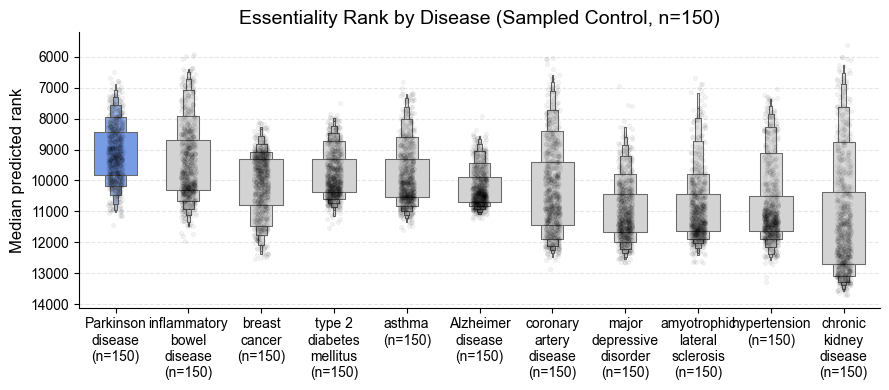

In [21]:
# Melt the dataframe for plotting
plot_df_sampled = (
    agg_rank_df_sampled
      .reset_index()
      .rename(columns={'index': 'node_name'})
      .melt(id_vars=['node_name'], value_vars=agg_rank_df_sampled.columns,
            var_name='Gene group', value_name='Aggregated rank')
)

plot_df_sampled['Gene group'] = plot_df_sampled['Gene group'].apply(lambda x: f"{x} (n={len(pc_gene_lists_sampled.get(x, []))})")

# Order by median rank
order_sampled = (plot_df_sampled
                 .groupby('Gene group')['Aggregated rank']
                 .median()
                 .sort_values(ascending=True)
                 .index)

plot_df_sampled['Gene group'] = pd.Categorical(plot_df_sampled['Gene group'],
                                               categories=order_sampled,
                                               ordered=True)

# Plot figure
plt.figure(figsize=(9, 4))

palette_sampled = {
    f"Parkinson disease (n={sample_size})" : '#6695F8',
}
for color in set(plot_df_sampled['Gene group']) - set(palette_sampled):
    palette_sampled[color] = '#D3D3D3'

sns.boxenplot(
    x='Gene group', y='Aggregated rank',
    data=plot_df_sampled, order=order_sampled,
    palette=palette_sampled, hue='Gene group',
    width=0.6, showfliers=False, zorder=3
)

sns.stripplot(
    x='Gene group', y='Aggregated rank',
    data=plot_df_sampled, jitter=True, dodge=True, order=order_sampled,
    alpha=0.05, color='black', linewidth=0.5, s=3, zorder=5
)

ax = plt.gca()
max_width = 12
wrapped_labels = ["\n".join(textwrap.wrap(tick.get_text(), width=max_width)).replace(" (", "\n(") for tick in ax.get_xticklabels()]
ticks = ax.get_xticks()
ax.set_xticks(ticks, labels=wrapped_labels, rotation=0)

plt.gca().invert_yaxis()
plt.title(f"Essentiality Rank by Disease (Sampled Control, n={sample_size})", fontsize=14)
plt.xlabel('')
plt.ylabel('Median predicted rank', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)
sns.despine(top=True, right=True)
plt.tight_layout()

plt.savefig(conf.paths.notebooks.essentiality_gwas_dir / 'essentiality_rank_boxplot_sampled.pdf', bbox_inches='tight')
plt.savefig(conf.paths.notebooks.essentiality_gwas_dir / 'essentiality_rank_boxplot_sampled.png', dpi=600, bbox_inches='tight')
plt.show()

Lastly, perform the Kruskal-Wallis test on the sampled data.

In [22]:
rank_data_for_sampled_test = [agg_rank_df_sampled[col].dropna() for col in agg_rank_df_sampled.columns]
stat_sampled, p_val_sampled = kruskal(*rank_data_for_sampled_test)

# Print the results
_logger.info(f'Kruskal-Wallis Test across all sampled {len(rank_data_for_sampled_test)} disease groups:')
_logger.info(f'H-statistic: {stat_sampled:.4f}')
_logger.info(f'P-value: {p_val_sampled:.4e}')

[12/10/25 13:35:36] INFO     Kruskal-Wallis Test across all sampled 11 disease groups:               ]8;id=426117;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/187442579.py\187442579.py]8;;\:]8;id=650810;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/187442579.py#5\5]8;;\

                    INFO     H-statistic: 2157.6367                                                  ]8;id=906604;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/187442579.py\187442579.py]8;;\:]8;id=170395;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/187442579.py#6\6]8;;\

                    INFO     P-value: 0.0000e+00                                                     ]8;id=25990;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/187442579.py\187442579.py]8;;\:]8;id=188073;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/187442579.py#7\7]8;;\

## Compare with NERINE

See paper [here](https://www.biorxiv.org/content/10.1101/2025.01.07.631688v3), autophagy genes are taken from Figure 6C and Supplementary Table 17.

In [23]:
# From Figure 6C
autophagy_genes = [
    "ATP6V0A2",
    "BAD",
    "CTSA",
    "DRAM2",
    "EXOC4",
    "HAX1",
    "HMGB1",
    "OPTN",
    "OSBPL7",
    "PIP4K2A",
    "PRKAA1",
    "TAB2",
    "USP10",
    "USP36",
]

# Print number of autophagy genes in essentiality genes
ess_autophagy_genes = essentiality_genes[essentiality_genes["node_name"].isin(autophagy_genes)]
_logger.info(f"Number of autophagy genes also essentiality genes: {len(ess_autophagy_genes)}")
_logger.info(f"Total number of autophagy genes: {len(autophagy_genes)}")
_logger.info(f"Total number of essentiality genes: {len(essentiality_genes)}")

                    INFO     Number of autophagy genes also essentiality genes: 14                 ]8;id=841204;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/4121834807.py\4121834807.py]8;;\:]8;id=702448;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/4121834807.py#21\21]8;;\

                    INFO     Total number of autophagy genes: 14                                   ]8;id=166931;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/4121834807.py\4121834807.py]8;;\:]8;id=825622;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/4121834807.py#22\22]8;;\

                    INFO     Total number of essentiality genes: 679                               ]8;id=900300;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/4121834807.py\4121834807.py]8;;\:]8;id=493554;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/4121834807.py#23\23]8;;\

In [24]:
autophagy_df = rank_mat[autophagy_genes]
autophagy_df = autophagy_df.reset_index().merge(
    essentiality_df[["node_name", "node_index"]], on="node_index", how="left"
)
autophagy_df = autophagy_df[["node_name", "node_index", *autophagy_genes]]

autophagy_PD_df = autophagy_df[autophagy_df["node_name"].isin(pc_gene_lists["Parkinson disease"]["node_name"])]
autophagy_non_PD_df = autophagy_df[~autophagy_df["node_name"].isin(pc_gene_lists["Parkinson disease"]["node_name"])]

In [25]:
rank_long_PD = (
    autophagy_PD_df.drop(columns=["node_index"])
    .melt(id_vars="node_name", var_name="Autophagy gene", value_name="Rank")
    .dropna(subset=["Rank"])
)

rank_long_non_PD = (
    autophagy_non_PD_df.drop(columns=["node_index"])
    .melt(id_vars="node_name", var_name="Autophagy gene", value_name="Rank")
    .dropna(subset=["Rank"])
)

In [26]:
RANK_K = 1  # how many "best" ranks to average
N = 100  # how many random resamples
S = len(pc_gene_lists["Parkinson disease"])  # sample size each time
rng = np.random.default_rng(conf.seed)  # reproducible randomness

pd_topk_mean = (
    rank_long_PD.groupby("Autophagy gene")["Rank"].apply(lambda s: s.nsmallest(RANK_K).mean()).rename("PD_topK_mean")
)

In [27]:
def one_draw(group, *, k, sample_size):
    """
    Take `sample_size` rows from the group, then return the mean
    of the k smallest ranks among those sampled rows.
    """
    # If the group is smaller than sample size, fall back to the whole group
    sample = group.sample(n=min(sample_size, len(group)), replace=False, random_state=rng.integers(0, 2**32))
    return sample["Rank"].min()


rand_results = rank_long_non_PD.groupby("Autophagy gene", group_keys=False).apply(
    lambda g: [one_draw(g, k=RANK_K, sample_size=S) for _ in range(N)], include_groups=False
)

rand_df = (
    rand_results.apply(pd.Series)
    .melt(ignore_index=False, var_name="iteration", value_name="rand_topK_mean")
    .reset_index()
)
rand_df["Group"] = "Random"

In [28]:
# Reshape for barplot
pd_bar = pd_topk_mean.rename("Score").reset_index()
pd_bar["Group"] = "PD GWAS hits"

rand_bar = rand_results.apply(np.mean).rename("Score").reset_index()
rand_bar["Group"] = "Random"

plot_df = pd.concat([pd_bar, rand_bar], ignore_index=True)

# Order genes by PD score
order = (pd_bar.sort_values("Score")["Autophagy gene"]).tolist()

palette = {"PD GWAS hits": "#6695F8", "Random": "#D3D3D3"}
point_palette = {"PD GWAS hits": "black", "Random": "black"}

Compute 95% CI as the mean ± t * (s / √n).

In [29]:
ci_df = rand_df.groupby(["Autophagy gene", "Group"])["rand_topK_mean"].agg(["mean", "count", "std"]).reset_index()
ci_df["ci_halfwidth"] = stats.t.ppf(0.975, ci_df["count"] - 1) * ci_df["std"] / ci_df["count"] ** 0.5
ci_df["y_low"] = ci_df["mean"] - ci_df["ci_halfwidth"]
ci_df["y_high"] = ci_df["mean"] + ci_df["ci_halfwidth"]

ci_df = ci_df.set_index("Autophagy gene")
ci_df = ci_df.reindex(order)
ci_df = ci_df.reset_index()

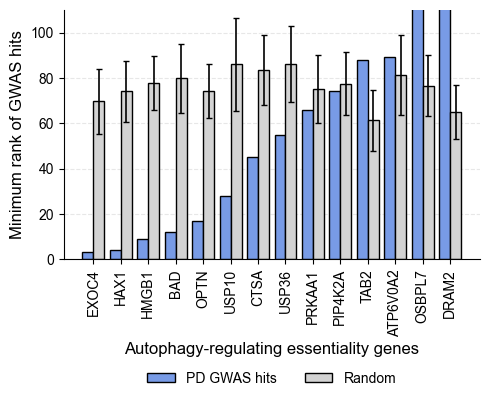

In [30]:
# Draw the plot
plt.figure(figsize=(5, 4.5))

ax = sns.barplot(
    x="Autophagy gene",
    y="Score",
    hue="Group",
    data=plot_df,
    order=order,
    palette=palette,
    edgecolor="black",
    width=0.8,
    zorder=2,
)

patch_width = ax.patches[0].get_width()

# Add the error bars
for i, row in ci_df.iterrows():
    ax.errorbar(
        x=i + patch_width / 2,
        y=row["mean"],
        yerr=[[row["mean"] - row["y_low"]], [row["y_high"] - row["mean"]]],
        fmt="none",
        ecolor="black",
        elinewidth=1.2,
        capsize=2,
        zorder=4,
    )

wrapped = ["\n".join(textwrap.wrap(g, width=8, break_long_words=True, break_on_hyphens=True)) for g in order]
ticks = ax.get_xticks()
ax.set_xticks(ticks, labels=wrapped, rotation=90)

ax.set_xlabel("Autophagy-regulating essentiality genes", fontsize=12)
ax.set_ylabel("Minimum rank of GWAS hits", fontsize=12)
ax.set_ylim(0, 110)

ax.grid(axis="y", linestyle="--", alpha=0.3, zorder=0)
sns.despine(top=True, right=True)

# Place legend below the plot
plt.legend(title="", frameon=False, loc="upper center", ncol=2, bbox_to_anchor=(0.5, -0.4))
plt.tight_layout()

# Save results
plt.savefig(conf.paths.notebooks.essentiality_gwas_dir / "autophagy_barplot.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.essentiality_gwas_dir / "autophagy_barplot.png", dpi=600, bbox_inches="tight")
plt.savefig(conf.paths.notebooks.essentiality_gwas_dir / "autophagy_barplot.svg", bbox_inches="tight")
plt.show()

Check the rank of OSBPL7 and DRAM2.

In [31]:
plot_df[plot_df["Autophagy gene"].isin(["OSBPL7", "DRAM2"])]

,Autophagy gene,Score,Group
3,DRAM2,538.00,PD GWAS hits
8,OSBPL7,400.00,PD GWAS hits
17,DRAM2,65.02,Random
22,OSBPL7,76.57,Random


Perform statistical tests to check if PD GWAS hits are preferentially linked to autophagy-regulating essentiality genes.

In [ ]:
# Number of random draws per gene
N_draws = int(rand_df.groupby('Autophagy gene')['iteration'].nunique().iloc[0])
gene_rand = (
    rand_df
      .pivot(index='Autophagy gene', columns='iteration', values='rand_topK_mean')
      .sort_index()
)

# Align PD scores to the same gene index
pd_scores = pd_topk_mean.reindex(gene_rand.index).rename('PD_stat')

def empirical_p_one_sided(pd_val, draws):
    """
    Empirical one-sided p-value: P(random <= PD) with +1 pseudo-counts.
    Lower ranks are better; small p means PD is better than random.
    """
    draws = np.asarray(draws, dtype=float)
    return (np.sum(draws <= pd_val)) / (len(draws))

rows = []
for g in gene_rand.index:
    draws = gene_rand.loc[g].dropna().values
    mu   = draws.mean()
    sd   = draws.std(ddof=1)
    # 95% CI of the random mean
    ci_lo, ci_hi = stats.t.interval(0.95, len(draws)-1, loc=mu, scale=sd/np.sqrt(len(draws)))
    # Empirical one-sided p
    p_emp = empirical_p_one_sided(pd_scores.loc[g], draws)
    # Effect size
    eff = (mu - pd_scores.loc[g]) / sd if sd > 0 else np.nan

    rows.append({
        'Autophagy gene': g,
        'PD_stat': float(pd_scores.loc[g]),
        'Random_mean': float(mu),
        'Random_sd': float(sd),
        'CI95_lo': float(ci_lo),
        'CI95_hi': float(ci_hi),
        'Effect_size_d': float(eff),
        'Empirical_p(one-sided)': float(p_emp),
    })

gene_summary = (
    pd.DataFrame(rows)
      .sort_values('Empirical_p(one-sided)')
      .reset_index(drop=True)
)

# Benjamini–Hochberg FDR across the 15 genes
gene_summary['FDR_BH'] = multipletests(gene_summary['Empirical_p(one-sided)'],
                                       method='fdr_bh')[1]

display_cols = ['Autophagy gene','PD_stat','Random_mean','Random_sd',
                'CI95_lo','CI95_hi','Effect_size_d','Empirical_p(one-sided)','FDR_BH']
pd.options.display.float_format = lambda x: f"{x:,.3f}"
_logger.info(gene_summary[display_cols].to_string(index=False))

# Global combined p-value
stat_fisher, p_fisher = stats.combine_pvalues(gene_summary['Empirical_p(one-sided)'], method='fisher')
_logger.info(f"\nFisher combined p-value across {len(gene_summary)} genes: stat = {stat_fisher:.2f}, p = {p_fisher:.3e}")

# How many genes have PD below/above the random 95% CI?
n_below = (gene_summary['PD_stat'] < gene_summary['CI95_lo']).sum()
_logger.info(f"Genes with PD_stat below random 95% CI: {n_below} / {len(gene_summary)}")
n_above = (gene_summary['PD_stat'] > gene_summary['CI95_hi']).sum()
_logger.info(f"Genes with PD_stat above random 95% CI: {n_above} / {len(gene_summary)}")

# Paired, across-gene test
diff = gene_summary['Random_mean'] - gene_summary['PD_stat']
w_stat, w_p = stats.wilcoxon(diff, alternative='greater')
_logger.info(f"Wilcoxon signed-rank (Random_mean - PD_stat > 0): W = {w_stat:.1f}, p = {w_p:.3e}")

out_csv = conf.paths.notebooks.essentiality_gwas_dir / 'autophagy_alignment_gene_stats.csv'
gene_summary.to_csv(out_csv, index=False)

[12/10/25 13:35:37] INFO     Autophagy gene  PD_stat  Random_mean  Random_sd  CI95_lo  CI95_hi     ]8;id=320015;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3141582698.py\3141582698.py]8;;\:]8;id=860394;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3141582698.py#57\57]8;;\
                             Effect_size_d  Empirical_p(one-sided)  FDR_BH                                         
                                       HAX1    4.000       74.120     67.679   60.691   87.549                     
                             1.036                   0.030   0.280                                                 
                                      EXOC4    3.000       69.730     72.256   55.393   84.067                     
                             0.924                   0.050   0.280                                                 
                                      HMGB1    9.000       77.800     60.345   65.826   89.774                     
                             1.140                   0.060   0.280                                                 
                                        BAD   12.000       79.730     77.665   64.320   95.140                     
                             0.872                   0.160   0.504                                                 
                                       OPTN   17.000       74.260     60.652   62.225   86.295                     
                             0.944                   0.180   0.504                                                 
                                      USP10   28.000       85.940    103.134   65.476  106.404                     
                             0.562                   0.280   0.653                                                 
                                       CTSA   45.000       83.460     77.847   68.013   98.907                     
                             0.494                   0.390   0.780                                                 
                                      USP36   55.000       86.180     84.564   69.401  102.959                     
                             0.369                   0.540   0.853                                                 
                                    PIP4K2A   74.000       77.460     70.825   63.407   91.513                     
                             0.049                   0.590   0.853                                                 
                                     PRKAA1   66.000       74.960     75.378   60.003   89.917                     
                             0.119                   0.620   0.853                                                 
                                   ATP6V0A2   89.000       81.440     88.997   63.781   99.099                     
                             -0.085                   0.670   0.853                                                
                                       TAB2   88.000       61.320     67.718   47.883   74.757                     
                             -0.394                   0.790   0.922                                                
                                      DRAM2  538.000       65.020     59.839   53.147   76.893                     
                             -7.904                   1.000   1.000                                                
                                     OSBPL7  400.000       76.570     67.887   63.100   90.040                     
                             -4.764                   1.000   1.000                                                

                    INFO                                                                           ]8;id=692094;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3141582698.py\3141582698.py]8;;\:]8;id=202511;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3141582698.py#61\61]8;;\
                             Fisher combined p-value across 14 genes: stat = 34.67, p = 1.796e-01                  

                    INFO     Genes with PD_stat below random 95% CI: 8 / 14                        ]8;id=810891;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3141582698.py\3141582698.py]8;;\:]8;id=292683;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3141582698.py#65\65]8;;\

                    INFO     Genes with PD_stat above random 95% CI: 3 / 14                        ]8;id=884642;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3141582698.py\3141582698.py]8;;\:]8;id=562262;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3141582698.py#67\67]8;;\

                    INFO     Wilcoxon signed-rank (Random_mean - PD_stat > 0): W = 72.0, p =       ]8;id=273903;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3141582698.py\3141582698.py]8;;\:]8;id=187241;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_53060/3141582698.py#72\72]8;;\
                             1.206e-01                                                                             